In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import utils
import numpy as np
from datasets import Dataset
   

/home/mourad/.conda/envs/mourad-econ-py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
local1 = pd.read_csv("/data/mourad/narratives/proquest/raw_from_TDM/local-data.csv.gz", compression="gzip", sep="\t")
local1['scope'] = 'local'
local2 = pd.read_csv("/data/mourad/narratives/proquest/raw_from_TDM/local-data-2.csv.gz", compression="gzip", sep="\t") 
local2['scope'] = 'local'
national1 = pd.read_csv("/data/mourad/narratives/proquest/raw_from_TDM/local-data-3-national.csv.gz", compression="gzip", sep="\t")
national1['scope'] = 'national'
old = pd.read_csv("/data/mourad/narratives/proquest/raw_from_TDM/processed-data-1923-1960.csv.gz", compression="gzip", sep="\t") 
old['scope'] = 'unknown'
recent = pd.read_csv("/data/mourad/narratives/proquest/raw_from_TDM/processed-data-2010-2025.csv.gz", compression="gzip", sep="\t")


df = pd.concat([local1, local2, national1, old, recent], axis=0)
## ONLY RECENT for new predictions
# df = recent
all = len(df)
df = df[df.text.notna()]
print("# of empty text: ", all - len(df))
df[['year','month']] = df['year_month'].str.split('-',expand=True)
# df = df.rename({"loc": "city"}, axis=1)
df.year = df.year.astype(int)
df.month = df.month.astype(int)

# of empty text:  210972


In [31]:
df.title.nunique()

868

In [40]:
titles = df[['title', 'year']]
# titles = titles.drop_duplicates()
titles

,title,year
0,Minneapolis Tribune (1964-1982),1968
1,Los Angeles Times (1923-1995),1993
2,St. Louis Post-Dispatch (1923-),1972
3,Minneapolis Star and Tribune (1982-1987),1983
4,Cincinnati Enquirer (1923-),1975
...,...,...
1263581,St. Joseph News - Press,2022
1263582,Targeted News Service,2024
1263583,Sun Journal,2024
1263584,"Clarion Ledger, The",2017


In [41]:
titles['start'] = titles.groupby('title')['year'].transform('min')
titles['end'] = titles.groupby('title')['year'].transform('max')
titles = titles.drop('year', axis=1)
# drop duplicates but add column with number of duplicates for each group
titles['count'] = titles.groupby(titles.columns.tolist())['title'].transform('count')

/tmp/ipykernel_3684088/2420409752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titles['start'] = titles.groupby('title')['year'].transform('min')
/tmp/ipykernel_3684088/2420409752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titles['end'] = titles.groupby('title')['year'].transform('max')


In [46]:
titles = titles.drop_duplicates()
titles = titles.sort_values(by='title')
titles.to_csv("../../data/general/newspaper_names.csv", index=False)

In [3]:
def extend_substrings(input_list):
    # Create a dictionary to store the transformation map
    transformation_map = {}

    # Filter out None values and sort the remaining input list by length in descending order
    filtered_list = [word for word in input_list if word is not None]
    sorted_list = sorted(filtered_list, key=len, reverse=True)

    for word in sorted_list:
        # Check if the word is a substring of any other longer word in the list
        for longer_word in utils.region_mapping.keys():# sorted_list:
            if longer_word.startswith(word) and word != longer_word:
                transformation_map[word] = longer_word
                break
        else:
            # If the word is not a substring of any other word, map it to itself
            transformation_map[word] = word

    # Add None mapping to None
    transformation_map[None] = None

    return transformation_map

def combine_cities(group):
    # group.state = group.state.str.strip()
    unique_states = group.state.unique()
    expand_states = extend_substrings(unique_states)
    
    group.state = group.state.map(expand_states)
    try:
        group.state = group.state.fillna(group.state.mode()[0])
    except:
        return group
    # if len(group.states.nunique() == 1:
    #     group.state = group.state.unique()[0]
    return group

def abbrev_to_full(state):
    if state is not None:
        no_space = state.replace(" ", "")
        if len(no_space) < 3:
            state = no_space
    if state in utils.state_abbreviation_to_name:
        return utils.state_abbreviation_to_name[state]
    return state

In [4]:
df['loc'] = df['loc'].str.replace(".", "")
df['loc'] = df['loc'].str.lower()
df[['city', 'state']] = df['loc'].str.split(',', n=1, expand=True)
df.state = df.state.str.strip()
df.state = df.state.apply(abbrev_to_full)

df.city = df.city.str.strip()
df = df.groupby(['city']).apply(combine_cities)
df.state = df.apply(lambda x: utils.missing_cities[x.city] if x.state is None and x.city in utils.missing_cities else x.state, axis=1)
df = df[~df.state.isin(['mexico'])]
df = df[df.state.notna()]
df = df.reset_index(drop=True)
df['region'] = df.state.map(utils.region_mapping)


/tmp/ipykernel_3684088/1204115852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loc'] = df['loc'].str.replace(".", "")
/tmp/ipykernel_3684088/1204115852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loc'] = df['loc'].str.lower()
/tmp/ipykernel_3684088/1204115852.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [9]:
# all_ds = Dataset.from_pandas(df)
# all_ds.save_to_disk("/data/mourad/narratives/proquest/full_proquest_processed_for_prediction")

#df.to_json('/data/mourad/narratives/proquest/processed_data_1923-2013.jsonl.gz', orient='records', lines=True, compression='gzip')
df.to_json('/data/mourad/narratives/proquest/processed_data_1923-2025.jsonl.gz', orient='records', lines=True, compression='gzip')
# df.to_json('/data/mourad/narratives/proquest/processed_data_2010-2025.jsonl.gz', orient='records', lines=True, compression='gzip')

In [8]:
df.title.value_counts()

title
Targeted News Service           182319
Wall Street Journal (Online)    128850
TCA Regional News                72347
New York Times (Online)          57036
PR Newswire                      56657
                                 ...  
San Francisco Chronicle              1
LatinoWire                           1
Call and Post (1982-)                1
New York Times Español               1
New Journal & Guide                  1
Name: count, Length: 516, dtype: int64

In [17]:
def sample_for_labeling(df, year_start, year_end, n=1499):
    random_state = 0
    period_df = df[(df.year >= year_start) & (df.year <= year_end)]
    period_df['id'] = period_df.index
    sampled = df.sample(n=n, random_state=random_state)
    
    subset_1 = sampled.iloc[:500]

    # Determine the sizes for the remaining three subsets
    remaining_rows = sampled.iloc[500:]
    num_remaining_rows = len(remaining_rows)
    subset_size = num_remaining_rows // 3

    # Create the remaining subsets programmatically
    subset_2 = remaining_rows.iloc[:subset_size]
    subset_3 = remaining_rows.iloc[subset_size:2*subset_size]
    subset_4 = remaining_rows.iloc[2*subset_size:]
    
    all = []
    for subset, annotator_name in [(subset_1, 'mh*'), (subset_1, 'az*'), (subset_1, 'qz*'), (subset_2, 'mh'), (subset_3, 'az'), (subset_4, 'qz')]:
        subset = subset.copy()
        subset['annotator'] = annotator_name
        all.append(subset)
        
    sampled = pd.concat(all, axis=0)
    
    # sampled.to_csv(f"../../data/for_labeling/proquest_{year_start}-{year_end}_n{n}_rand{random_state}_v1_061124.csv", index=False)
    return period_df, sampled

In [18]:
period_df, sampled = sample_for_labeling(df, 1960, 1980)
period_df.to_json('/data/mourad/narratives/proquest/processed_data_1960-1980.jsonl.gz', orient='records', lines=True, compression='gzip')

/tmp/ipykernel_2115842/3138960123.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['id'] = period_df.index


In [10]:
period_df

,file_id,year_month,title,loc,text,scope,year,month,city,state,region
22886,491521216,1979-04,Atlanta Daily World (1932-),"atlanta, ga",Although wage and price controls have been pop...,local,1979,4,atlanta,georgia,southeast
22887,491521216,1979-04,Atlanta Daily World (1932-),"atlanta, ga","""Forty Centuries of Wage and Price Controls: H...",local,1979,4,atlanta,georgia,southeast
22888,491521216,1979-04,Atlanta Daily World (1932-),"atlanta, ga","""While there have been some cases in wht^h con...",local,1979,4,atlanta,georgia,southeast
22889,491521216,1979-04,Atlanta Daily World (1932-),"atlanta, ga",The basic reason for this is that they have no...,local,1979,4,atlanta,georgia,southeast
22890,491521216,1979-04,Atlanta Daily World (1932-),"atlanta, ga","When these measures resulted in inflation, the...",local,1979,4,atlanta,georgia,southeast
...,...,...,...,...,...,...,...,...,...,...,...
3630587,146246447,1975-02,Washington Post (1974-) The,"washington, dc",Ford seeks to impose as a conI servation measu...,national,1975,2,washington,district of columbia,northeast
3630589,146539826,1976-10,Washington Post (1974-) The,"washington, dc","Il,, the big in the neighborhood are t...",national,1976,10,washington,district of columbia,northeast
3634563,141116848,1960-01,"Washington Post, Times Herald (1959-1973) The","washington, dc",All British talents were concentrated on the o...,unknown,1960,1,washington,district of columbia,northeast
3634564,141116848,1960-01,"Washington Post, Times Herald (1959-1973) The","washington, dc",It would he expected who project themselves f...,unknown,1960,1,washington,district of columbia,northeast


In [12]:
sampled[sampled.annotator=='mh']

,file_id,year_month,title,loc,text,scope,year,month,city,state,region,annotator
2515121,133782723,1973-06,Wall Street Journal (1923-),"new york, ny","Also, major labor groups have formed a ""nation...",national,1973,6,new york,new york,northeast,mh
1510372,1908243394,1980-01,Tennessean (1972-) The,nashville,"In the first place, inflation will be accelera...",local,1980,1,nashville,tennessee,southeast,mh
529392,1888433497,1971-02,Cincinnati Enquirer (1923-),cincinnati,I SPECIAL LOW PRICES ON ALL WESTINGHOUSE ELECT...,local,1971,2,cincinnati,ohio,midwest,mh
3166183,148014272,1971-05,"Washington Post, Times Herald (1959-1973) The","washington, dc","Yet as a vicious Yugoslav inflation bit, Baral...",national,1971,5,washington,district of columbia,northeast,mh
811114,1893459522,1980-04,Indianapolis Star (1923-),indianapolis,But Mercer says only Social Security can index...,local,1980,4,indianapolis,indiana,midwest,mh
...,...,...,...,...,...,...,...,...,...,...,...,...
2809239,1901840902,1978-05,St. Louis Post-Dispatch (1923-),st louis,But his replies to questions about inflation a...,local,1978,5,st louis,missouri,midwest,mh
2379644,133889272,1974-12,Wall Street Journal (1923-),"new york, ny",That's twice the inflation rate that prevailed...,national,1974,12,new york,new york,northeast,mh
1074105,158794386,1979-04,Los Angeles Times (1923-1995),"los angeles, calif",Inflation is caused by labor costs rising fast...,local,1979,4,los angeles,california,west,mh
271596,171152257,1974-11,Chicago Tribune (1963-1996),"chicago, ill",The anti-inflation tactics adopted by Ms. Port...,local,1974,11,chicago,illinois,midwest,mh


In [68]:
df[df.state == 'minnesota'].title.value_counts()

title
Minneapolis Tribune (1964-1982)                49474
Minneapolis Star (1947-1982)                   34871
Star Tribune (1987-)                           23527
Star Tribune                                   14370
Minneapolis Star and Tribune (1982-1987)       11367
Minneapolis Morning Tribune (1939-1964) The     1129
St. Cloud Times                                  669
MinnPost.com                                     122
Sentinel                                           3
Duluthian The                                      1
Independent                                        1
Mpls. St. Paul                                     1
Name: count, dtype: int64

In [52]:
x=df.copy()
# x.groupby(['city', 'state']).size()
# x.drop_duplicates(subset=['city', 'state'])[x.drop_duplicates(subset=['city', 'state']).city.duplicated()]
# x[x.city == 'augusta']
# loc_keep = x[['state']].value_counts() > 1000
# x.state.value_counts()
# x.groupby('region').title.value_counts()
# df[df.state.isna()][['title', 'city']].value_counts()
# for name, row in df[df.state.isna()][['title', 'city']].value_counts().reset_index().iterrows():
#     print(row.city, "/", row.title, "/", row['count'])


In [34]:
x.state.nunique()

52

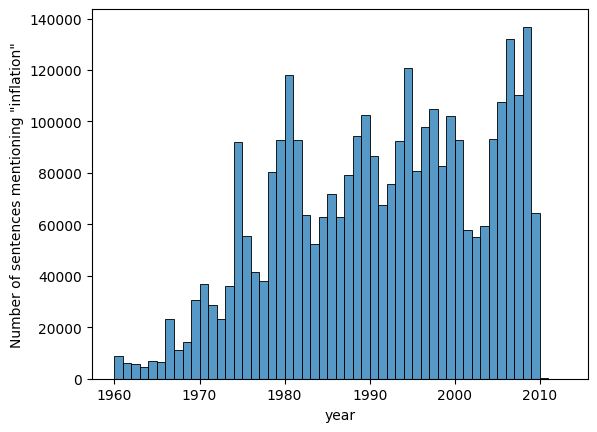

In [53]:
sns.histplot(data=df, x='year', binwidth=1)
plt.ylabel('Number of sentences mentioning "inflation"')
plt.show()

<Axes: xlabel='scope', ylabel='Number of sentences mentioning "inflation"'>

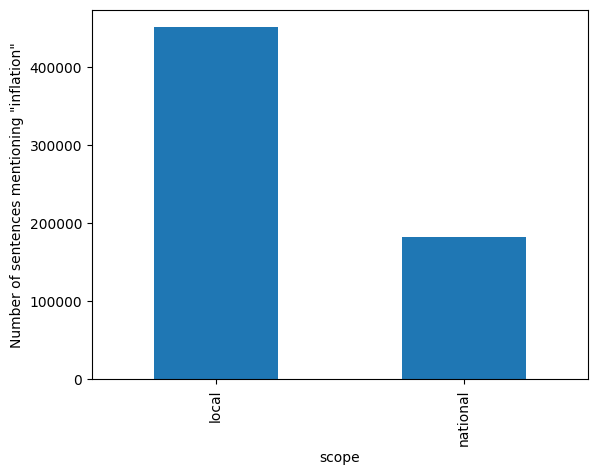

In [61]:
x[(x.year > 1960) & (x.year < 1980)]['scope'].value_counts(normalize=False).plot(kind='bar', ylabel='Number of sentences mentioning "inflation"')

<Axes: xlabel='region', ylabel='Number of sentences mentioning "inflation"'>

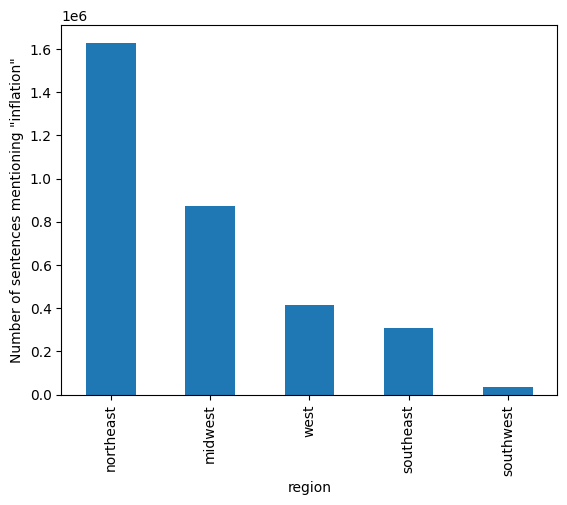

In [62]:
x['region'].value_counts(normalize=False).plot(kind='bar', ylabel='Number of sentences mentioning "inflation"')

30463


<Axes: xlabel='region', ylabel='Counts'>

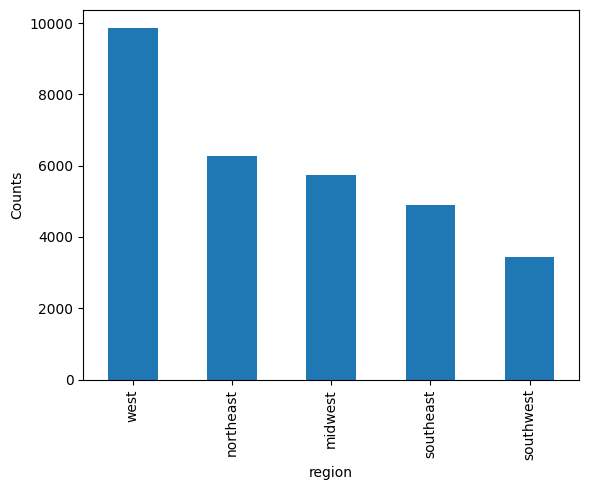

In [5]:
df = pd.read_csv("../../data/cause_and_locations.tsv", sep="\t")
print(len(df[df.scope != "National"]))
df[df.scope != "National"].region.value_counts().plot(kind='bar', ylabel='Counts')

30463


<Axes: xlabel='region', ylabel='Counts'>

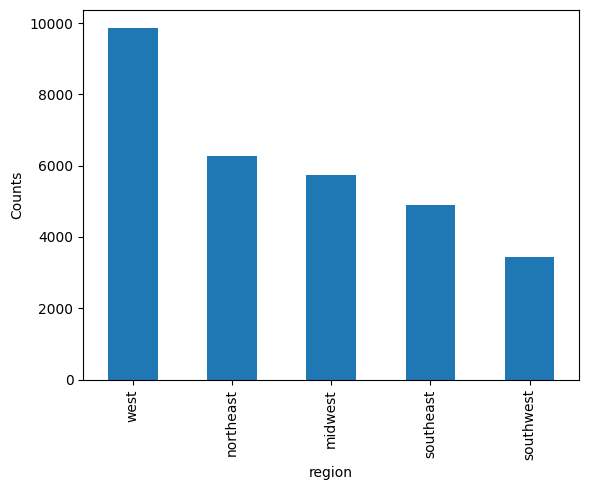

In [6]:
df = pd.read_csv("../../data/effect_and_locations.tsv", sep="\t")
print(len(df[df.scope != "National"]))
df[df.scope != "National"].region.value_counts().plot(kind='bar', ylabel='Counts')

In [4]:
import json
train_data = utils.load_hf_dataset(path="/data/mourad/narratives/sft_data_proquest")['train']
test_data = utils.load_hf_dataset(path="/data/mourad/narratives/sft_data_proquest")['test']

def fmt_instance(sentence, output):
    # return '{"messages": [{"role": "user", "content": "' + sentence + '"}, {"role": "assistant", "content": \"' + json.dumps(output) + '"}]}'
    return {
        "messages": [
            {"role": "user", "content": sentence},
            {"role": "assistant", "content": json.dumps(output)}
        ]
    }


In [5]:
train_json = []
for instance in train_data:
    gold = json.loads(utils.reconstruct_training_input(instance))
    train_json.append(fmt_instance(instance['text'], gold))
    
test_json = []
for instance in test_data:
    test = json.loads(utils.reconstruct_training_input(instance))
    test_json.append(fmt_instance(instance['text'], test))

In [6]:
#print each sentence in test
for i in test_json:
    print(i['messages'][0]['content'])
    # print(i['messages'][1]['content'])
    print()

In the first instance, accelerating inflation has driven the replacement cost of capital, in its physical sense, to substantially above the capital consumption allowances chargeable against historical cost.

she said,"but the old folks are still caught in an inflation squeeze.

"Congress' action was part of a general response to inflation....

The White House Council on Wage and Price Stability, meanwhile, issued its own inflation report.

DRUM CORPS NOTES Inflation woes hit contest sponsor groups By Herb Cole Contest sponsors will have to bear an even greater brunt of inflation.

', Goldfinger and other labbr spokesmen have blamed Nixon's policies of tight money, money, high interest and federal budget cuts last year for boosting unemployment afid curbing business without stopping stopping inflation.

A TOUGH PROGRAM New Regulations Go Into Effect Aug. 12 in Other Sectors By EDWARD COWAN Sprclul to Ille New York frames WASHINGTON, July 18 President Nixon ended the freeze today on pric

In [ ]:
# with open("../prompt-templates/in-context/claude/fewshot_train_200_samples.txt", "w") as f:

In [56]:
# randomly sample 200 items from golds
# import random
# random.seed(0)
# golds = random.sample(golds, 200)

# write each instance in golds to a new line in a file
with open("../prompt-templates/sft/gpt4omini-ft/train.jsonl", "w") as f:
    for train in train_json:
        f.write(json.dumps(train) + "\n")
        
with open("../prompt-templates/sft/gpt4omini-ft/test.jsonl", "w") as f:
    for test in test_json:
        f.write(json.dumps(test) + "\n")